### Monte Carlo Data Set for Qubit State Preparation and Measurement

Below I give a brief explination of qubit detection along with the types of errors we hope to correct using machine learning techniques. I first generate small trial data sets and plot the results. I follow that with generating a large Monte Carlo data set, again plottng the results. If you just want to generate new data set, skip to the section "Generate New MC Data Set".

A fundamental requirement of quantum computing is the initialization and readout of a quantum bit (qubit). In our experiment, we use a single trapped ion as a qubit, with each qubit level defined on a long-lived electronic state. Readout of either qubit state is achieved by collecting spontaneously emited photons, where an ion in the $\vert 0\rangle$ state will emit many photons ("bright state"), and an ion in the $\vert 1\rangle$ state will emit very few ("dark state"). The standard technique for discriminating between the two states is achieved by defining a threshold ($N_{th}$) on the number of collected photons, where collecting more than $N_{th}$ photons is declared bright,and less than or equal to $N_{th}$ is declared dark. One of the current limitations of this technique is the leakage from the $\vert 1\rangle$ to $\vert 0 \rangle$ state, or dark to bright. In this case, an ion that started dark becomes bright at some point during the detection window, and can result in the number of collected photons to be greater than $N_{th}$, resulting missidentification of the original qubit state. 

By using arivial times of the collected photons, we hope to correct for some of these leakage erros. In the event of leakage, we expect to see very few photons early in the detection window, followed by many photons late in the detection window. Using machine learning techniques applied to monte carlo data sets, we hope to improve detection and correction of these leakage events.

### Bright State

Detection of either qubit state is achieved by collecting spontaneously emited photons for 4.5 ms. When starting in the bright state, the distribution of collected photons is Poissonian, with the mean ($\lambda_B$) given by the average detection rate ($R_B$) multiplied by the detection time ($t_D$):

$$\large P(n) = \frac{\lambda_B^n}{n!}e^{-\lambda_B}$$.

To simulate real photon arivial data, we divide the detection window $t_D$ into $N_{bins}$ sub bins $t_i = \frac{t_D}{N_{bins}}$. The photon distribution in each sub bin will also follow a Poisson distribution, with new mean given by $\lambda_{B_i} = R_Bt_i$.

$$\large P(n)_{B_i} = \frac{\lambda_{B_i}^n}{n!}e^{-\lambda_{B_i}}$$

For a given trial, we first determine how many photons were detected in each sub bin using $P(n)_{B_i}$. Each photon then gets assigned a random time somewhere in that bin by sampling from a uniform distribution. This approach should be valid assuming $t_i << t_D$ and $P(n>1)_{B_i} << 1$.

Below I calculate a sample data set and plot a histogram of the generated photon arival times.

41 41
[0.00011813 0.00021933 0.00037026 0.0004902  0.00071464 0.00070177
 0.00076052 0.00083222 0.00090687 0.0009233  0.00106929 0.00109022
 0.00149003 0.0015075  0.00164947 0.00188339 0.00184723 0.00214602
 0.0022133  0.00225798 0.00225851 0.00249339 0.00284712 0.00291264
 0.00291876 0.0030041  0.00302335 0.00308347 0.00307236 0.00314171
 0.00318028 0.00331827 0.00360638 0.00365592 0.00371631 0.00398362
 0.00405863 0.00431043 0.00429591 0.00434879 0.00440394]


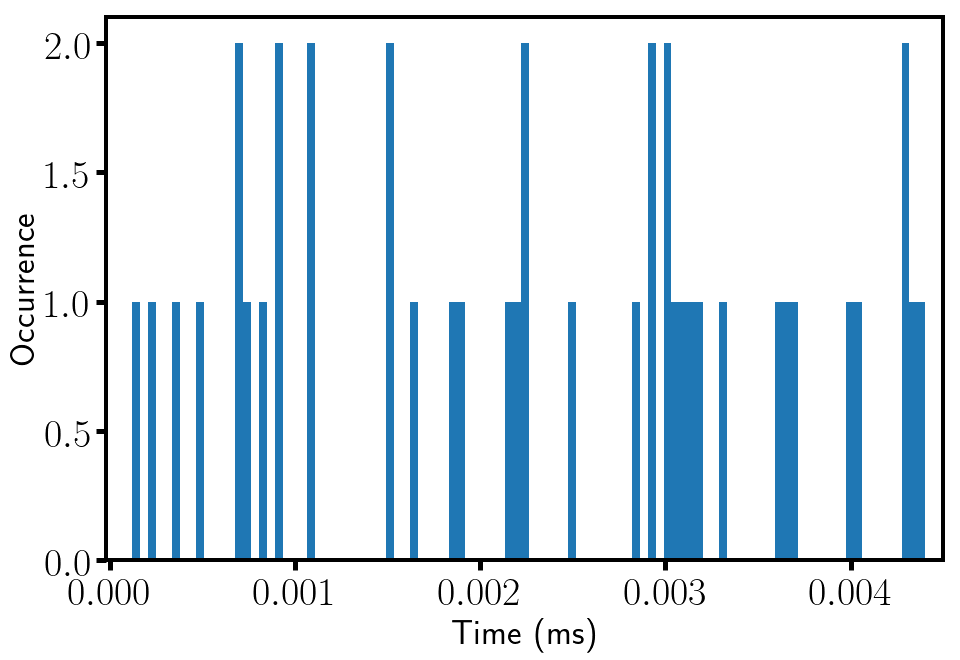

In [153]:
# For plotting config
rcParams['axes.linewidth'] = 4
rcParams["figure.figsize"] = 15, 10

# Definitions
lam_b = 39.6 # average number of photons collected during 4.5 ms detection
td = 4.5e-3 # detection window
Rb = lam_b/td # photons/sec
N_sub = 100 # P(n>1) = 0.05
lam_sub = lam_b/N_sub
ti = td/N_sub # sub bin time

# Sample from Poisson for each sub bin
b_photons = np.random.poisson(lam_sub, int(N_sub))
# we can now look at bins with photons and assign them a random arival time

bright_time_tags = np.array([])
#iterate through each bin
for i in range(N_sub):
    # grab the number of photons per bin and  assign a random arival time
    for j in range(b_photons[i]):
        bright_time_tags = np.append(bright_time_tags, ti*(i) + np.random.random(1)*ti)

# check we're creating the correct number of photon time tags
print np.sum(b_photons), len(bright_time_tags)        
# check the times look right
print bright_time_tags        
    
bins = np.arange(0,N_sub,1)*ti
#print bins
#print b_photons
#bar(bins , b_photons , width = ti)
hist(bright_time_tags, bins = 100)
xlabel(r'Time (ms)', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 40)
tick_params(width=5, length=10)
xlim([-ti/2,4.5e-3])
show()

### Dark State

For an ion that starts in the dark state, spontaneous emission can cause decay to the bright state during the detection window.
For the case where the ion stays in the dark state during detection, the distribution of collected photons is Poissonian, with the mean ($\lambda_D$) given by the average detection rate ($R_D$) multiplied by the detection time ($t_D$):

$$\large P(n) = \frac{\lambda_D^n}{n!}e^{-\lambda_D}$$.

As before, we divide the detection window $t_D$ into $N_{bins}$ sub bins $t_i = \frac{t_D}{N_{bins}}$. The photon distribution in each sub bin will also follow a Poisson distribution with new mean given by $\lambda_{D_i} = R_Dt_i$.

$$\large P(n)_{D_i} = \frac{\lambda_{D_i}^n}{n!}e^{-\lambda_{D_i}}$$.

We follow the same prescription as the bright state to dermine the number of photons per bin, and assign an arrival time to each.

To generate leakage events, we first need to determine the decay time $t_{\mathrm{decay}}$. The p.d.f. describing leakage from dark to bright is given by an exponental distribution:

$$\large f(t) = \frac{1}{\tau}e^{-t/\tau}$$

where $\tau \approx 31$s is the average leak time, and given by the lifetime of the dark state in our ion. To generate data with decays, we first sample from this distribution to determine detection attempts where a decay occurred. 
We then generate photon arrival times as previously described, where each sub bin with $t \leq t_{\mathrm{decay}}$ follows $P(n)_{D_i}$, and each sub bin with $t >  t_{\mathrm{decay}}$ follows $P(n)_{B_i}$. 

To simplfy the math and coding, we assume the decay occured at the end of relevant the sub bin, and sample from $P(n)_{D_i}$ to determine if a photon was observed. As long as $t_i << t_D$ this assumption is valid.


Below we generate photon distributions for dark state detection with and without decays during detection.

### Dark State No Decay

3 3
[0.00161451 0.0032519  0.00436789]


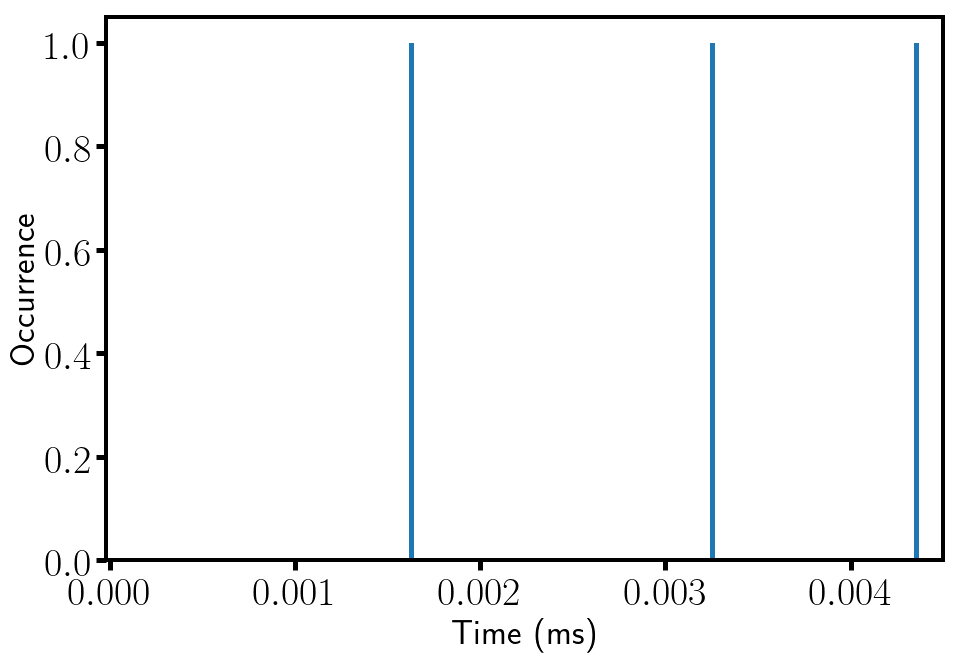

In [154]:
# Dark state no decay
# For plotting config
rcParams['axes.linewidth'] = 4
rcParams["figure.figsize"] = 15, 10

# Definitions
lam_d = 1.6 # average number of photons collected during 4.5 ms detection when in dark state
td = 4.5e-3 # detection window
Rd = lam_d/td # photons/sec
N_sub = 100 # We choose N_sub to get one photon on average in each sub bin when bright
lam_sub_d = lam_d/N_sub
ti = td/N_sub # sub bin time

# Sample from Poisson for each sub bin
d_photons = np.random.poisson(lam_sub_d, int(N_sub))

# we can now look at bins with photons and assign them a random arival time
dark_time_tags = np.array([])
#iterate through each bin
for i in range(N_sub):
    # grab the number of photons per bin and  assign a random arival time
    for j in range(d_photons[i]):
        dark_time_tags = np.append(dark_time_tags, ti*(i) + np.random.random(1)*ti)

# check we're creating the correct number of photon time tags
print np.sum(d_photons), len(dark_time_tags)        
# check the times look right
print dark_time_tags  



#bins = np.arange(0,N_sub,1)*ti
#print bins
#print b_photons
#bar(bins , d_photons , width = ti)
hist(dark_time_tags, bins = 100)
xlabel(r'Time (ms)', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 40)
tick_params(width=5, length=10)
xlim([-ti/2,4.5e-3])
show()

### Dark State With Decay

First lets check Pythons exponential sampling function and make sure it trends to the correct time constant.

Fitted value of time constatn:  31.4 s


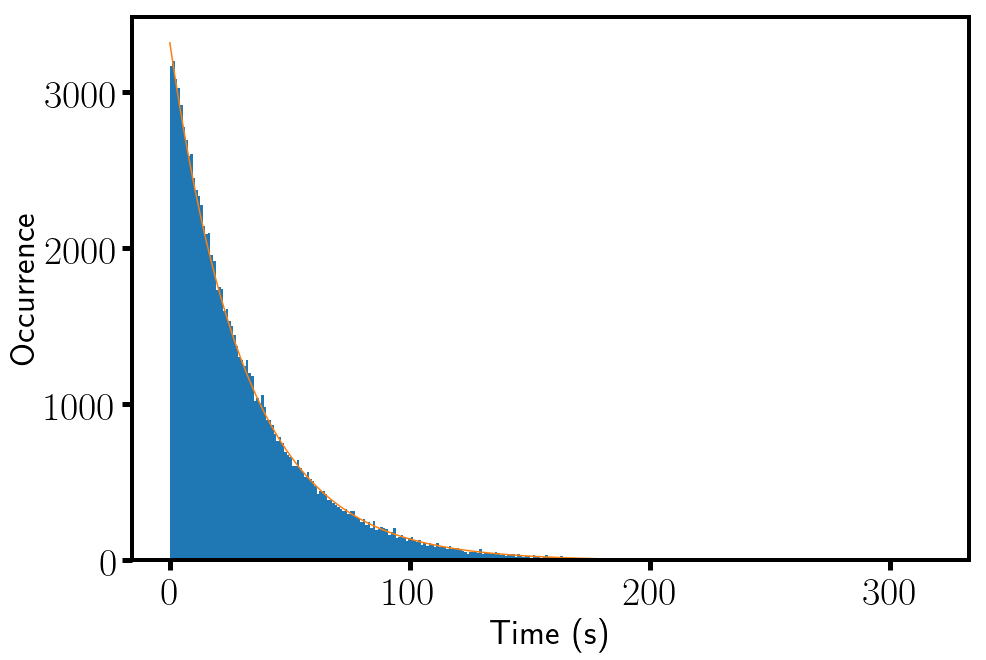

In [168]:
from scipy.optimize import curve_fit
### Sample from exponential distribution
tau = 31.0 # dark state lifetime
N = int(1e5) # sampling events
# Generate data
data = np.random.exponential(tau, N)

# Another way to sample from an exponential distribution
#data = -31*np.log(np.random.random(N))

# max bin value
m = np.amax(data)
# number of bins in histogram
n_bins = int(300)

#plot hist
h = hist(data, bins = n_bins, range = (0,m), align = 'mid')

# define function to fit sampled data to
def decay(t, tau, A):
    return A*np.exp(-t/tau)/tau

# fit sampled data
fit, err = curve_fit(decay, h[1][:-1], h[0], p0 = [31., N])

# plot sampled data over hist
y_fit = decay(h[1],fit[0], fit[1])
plot(h[1], y_fit)

# print fitted time constant
print 'Fitted value of time constatn: ',  '{:.1f}'.format(fit[0]) + ' s'

xlabel(r'Time (s)', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 40)
tick_params(width=5, length=10)
show()

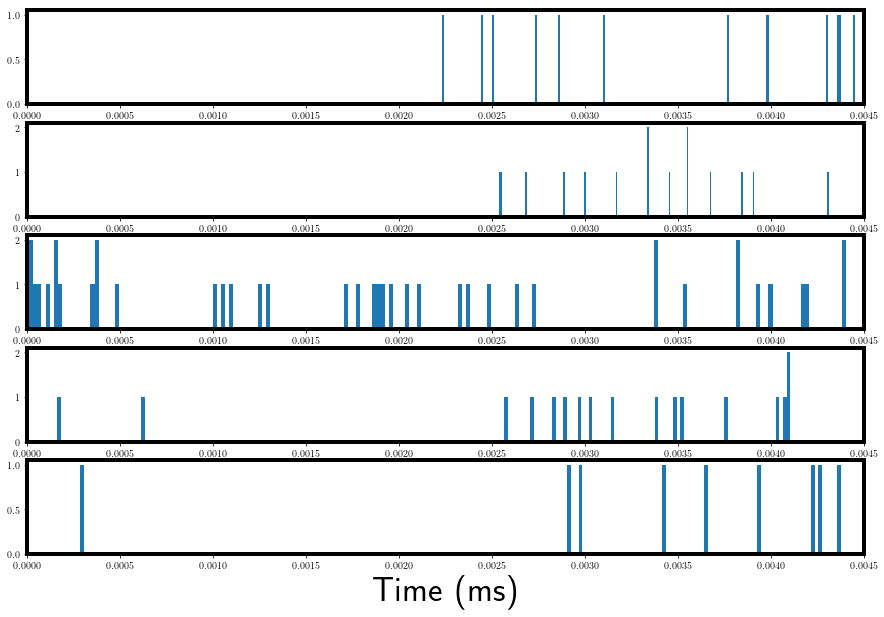

In [162]:
### events with decay

# Definitions
lam_b = 39.6 # average number of photons collected during 4.5 ms detection
lam_d = 1.6 # average number of photons collected during 4.5 ms detection when in dark state
td = 4.5e-3 # detection window
N_sub = 1000. # We choose N_sub to get one photon on average in each sub bin when bright
lam_sub_d = lam_d/N_sub # dark sub bin mean
lam_sub_b = lam_b/N_sub # bright sub bin mean
ti = td/N_sub # sub bin time
tau = 31.0 # dark state lifetime
N = int(1e5) # sampling events

# Generate data
data = np.random.exponential(tau, N)

# find events during the detection window
event_ind = np.where(data < td)
decay_events = data[event_ind[0]]

# determine which sub bin each event occurred in
decay_bin = floor(decay_events/ti) + 1
# Each element in decay bin is the number of dark state bins in each trial we need to sample from
# sum of the array decay_bin is the total number of dark state bins we need to sample
dark_bin_counts = np.random.poisson(lam_sub_d, int(np.sum(decay_bin)))

bright_bins = N_sub - decay_bin 
# (N_sub - decay_bin ) is an array of the number of bright bins in each decay event we need to sample
# the the sum of (N_sub-decay_bin) is the total numbe of bright bins we need to sample
bright_bin_counts = np.random.poisson(lam_sub_b, int(np.sum(bright_bins)))

# Now we just need to extract and concatenate the two photon distributions for each event
# I need to create an array which gives the starting postion of each new data set for the
# sampled distributions
count_ind_b = np.zeros(len(decay_bin))
count_ind_d = np.zeros(len(decay_bin))
for i in range(len(decay_bin)):
    count_ind_d[i] = np.sum(decay_bin[:i+1])
    count_ind_b[i] = np.sum(bright_bins[:i+1])

# now we use split to grab the distributions for each
d_counts = np.split(dark_bin_counts, count_ind_d.astype(int))
b_counts = np.split(bright_bin_counts, count_ind_b.astype(int))

# Now assign times and stich each bright and dark set together. 
# create an array to hold each trial
dark_tags_by_trial = []
for i in range((len(decay_events))):
    # creat array to store current trial tags
    dark_time_tags = np.array([])
    # do the dark counts
    for j in range(len(d_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(d_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)
    # do the bright counts
    for j in range(len(b_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(b_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j+ decay_bin[i]) + np.random.random(1)*ti)    
        
    dark_tags_by_trial.append(dark_time_tags)
    # check that we added the correct number of tags
    #print np.sum(d_counts[i]) + np.sum(b_counts[i]), len(dark_time_tags)

#all_tags = np.concatenate(dark_tags_by_trial).ravel()
#print all_tags
#hist(all_tags, bins = 100)

# lets plot the first 5
for i in range(5):
    subplot(5,1,i+1)
    hist(dark_tags_by_trial[i] , bins = 200)
    xlim([0,4.5e-3])
xlabel(r'Time (ms)', fontsize = 35)
#ylabel(r'Occurrence', fontsize = 35)
#tick_params(labelsize = 20)
#tick_params(width=5, length=10)    
show()


# Generate New MC Data Set

The top of the cell contains parameters that can be changed. To generate a new data set, change the values accordingly and run the cell. There will be approximately 10 decay events for every 100,000 dark state trials.

In [171]:
# Change parameters of the data set here
###################################
N = int(1e5) # number of detection trials for each qubit state
N_sub = 100 # number of sub bins. We choose N_sub to get one photon on average in each sub bin when bright

# save the data, must have .csv extension in file name
save_data = False
bright_tags_file_name = 'bright_tags_by_trial_MC.csv'
dark_tags_no_decay_file_name = 'dark_tags_by_trial_no_decay_MC.csv'
dark_tags_with_decay_file_name =  'dark_tags_by_trial_with_decay_MC.csv'

###################################
# Definitions
lam_b = 39.6 # average number of photons collected during 4.5 ms detection when in bright state
lam_d = 1.6 # average number of photons collected during 4.5 ms detection when in dark state
td = 4.5e-3 # detection window

lam_sub_d = lam_d/N_sub # dark sub bin mean
lam_sub_b = lam_b/N_sub # bright sub bin mean
ti = td/N_sub # sub bin time
tau = 31.0 # dark state lifetime
N = int(N) # sampling events


####################################
# first generate bright state data

# Sample from Poisson for each sub bin when bright
bright_state_trials = np.reshape(np.random.poisson(lam_sub_b, int(N_sub*N)),(N,int(N_sub)))
# That was easy...
# Now add tags
bright_tags_by_trial = []
#iterate through each trial
for i in range(N):
    # grab the number of photons per bin and  assign a random arival time
    # array to hold tags by trial
    bright_time_tags = np.array([])
    for j in range(N_sub):
        for k in range(bright_state_trials[i][j]):
            bright_time_tags = np.append(bright_time_tags, ti*(j) + np.random.random(1)*ti)

    bright_tags_by_trial.append(bright_time_tags)  

if save_data == True:
    import csv
    with open(bright_tags_file_name,'wb') as myfile:
      wr = csv.writer(myfile)
      wr.writerows(bright_tags_by_trial)

####################################
# now the dark state without decay

# Generate decay data
data = np.random.exponential(tau, N)

# find events during the detection window
event_ind = np.where(data < td)
decay_events = data[event_ind[0]]
print len(decay_events)
# create new array of events without decay
no_decay_events = np.delete(data, event_ind[0])

# do no decays first
dark_state_trials_no_decay = np.reshape(np.random.poisson(lam_sub_d, int(N_sub*len(no_decay_events))),(len(no_decay_events),int(N_sub)))

dark_tags_by_trial_no_decay = []
#iterate through each trial
for i in range(len(no_decay_events)):
    # grab the number of photons per bin and  assign a random arival time
    # array to hold tags by trial
    dark_time_tags = np.array([])
    for j in range(N_sub):
        for k in range(dark_state_trials_no_decay[i][j]):
            dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)

    dark_tags_by_trial_no_decay.append(dark_time_tags)                                        

if save_data == True:
    import csv
    with open(dark_tags_no_decay_file_name,'wb') as myfile:
      wr = csv.writer(myfile) 
      wr.writerows(dark_tags_by_trial_no_decay)


######################################
# dark state with decays
# determine which sub bin each event occurred in
decay_bin = floor(decay_events/ti)
# Each element in decay bin is the number of dark state bins in each trial we need to sample from
# sum of the array decay_bin is the total number of dark state bins we need to sample
dark_bin_counts = np.random.poisson(lam_sub_d, int(np.sum(decay_bin)))

bright_bins = N_sub - decay_bin 
# (N_sub - decay_bin ) is an array of the number of bright bins in each decay event we need to sample
# the the sum of (N_sub-decay_bin) is the total numbe of bright bins we need to sample
bright_bin_counts = np.random.poisson(lam_sub_b, int(np.sum(bright_bins)))

# Now we just need to extract and concatenate the two photon distributions for each event
# I need to create an array which gives the starting postion of each new data set for the
# sampled distributions
count_ind_b = np.zeros(len(decay_bin))
count_ind_d = np.zeros(len(decay_bin))
for i in range(len(decay_bin)):
    count_ind_d[i] = np.sum(decay_bin[:i+1])
    count_ind_b[i] = np.sum(bright_bins[:i+1])

# now we use split to grab the distributions for each
d_counts = np.split(dark_bin_counts, count_ind_d.astype(int))
b_counts = np.split(bright_bin_counts, count_ind_b.astype(int))

# Now assign times and stich each bright and dark set together. 
# create an array to hold each trial
dark_tags_by_trial_decay = []
for i in range((len(decay_events))):
    # creat array to store current trial tags
    dark_time_tags = np.array([])
    # do the dark counts
    for j in range(len(d_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(d_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j) + np.random.random(1)*ti)
    # do the bright counts
    for j in range(len(b_counts[i])):
        # grab the number of photons per bin and  assign a random arival time
            for k in range(b_counts[i][j]):
                dark_time_tags = np.append(dark_time_tags, ti*(j+ decay_bin[i]) + np.random.random(1)*ti)    
        
    dark_tags_by_trial_decay.append(dark_time_tags)
    
if save_data == True:
    import csv
    with open(dark_tags_with_decay_file_name,'wb') as myfile:
      wr = csv.writer(myfile) 
      wr.writerows(dark_tags_by_trial_decay)


14


## Plot the above data to make sure it looks right

### Bright State

Bright Fit Poisson Mean:  39.61


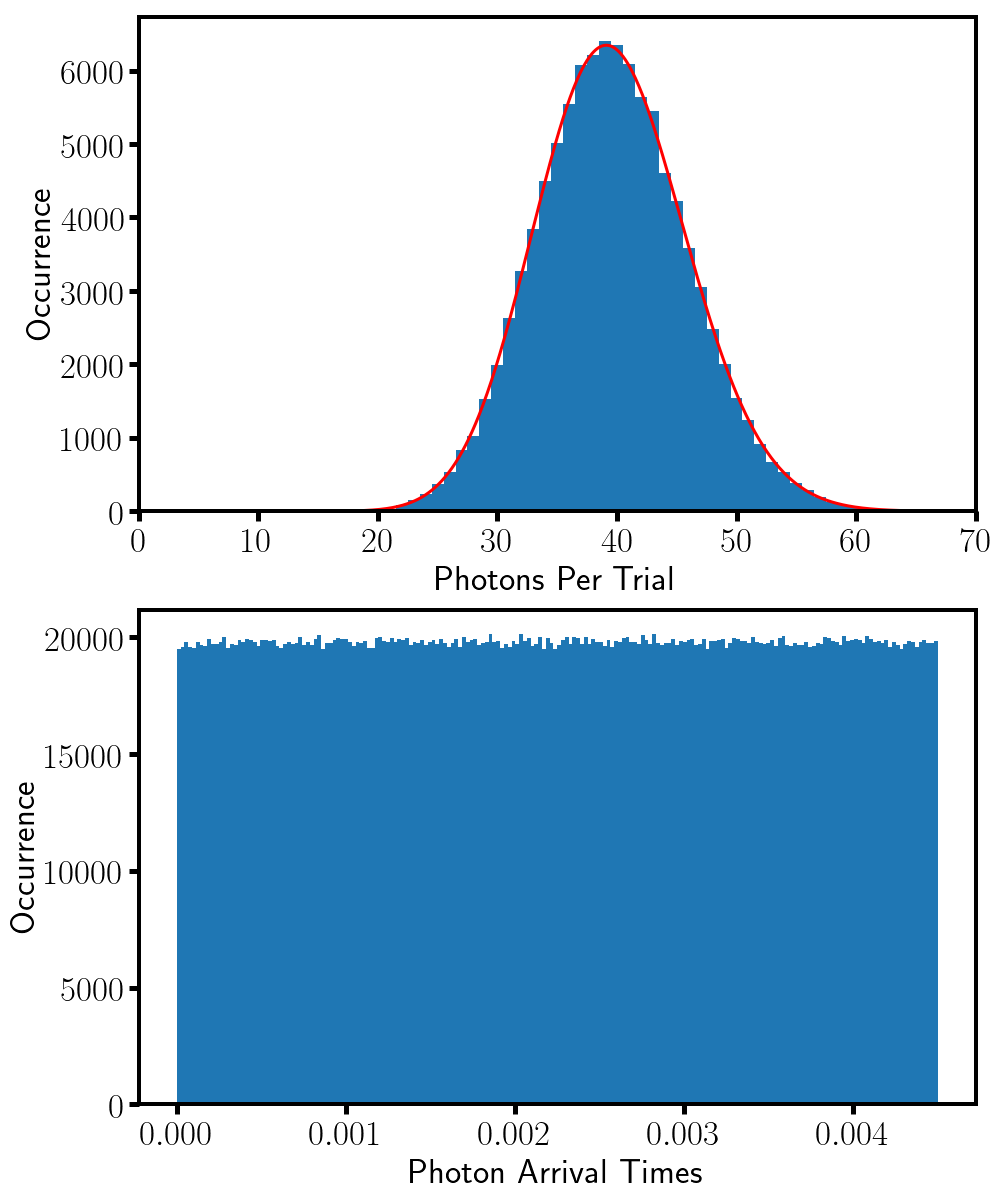

In [172]:
rcParams["figure.figsize"] = 15, 20
### Bright state


from scipy.optimize import curve_fit
from scipy.special import factorial

def poiss(x, mu):
        return (np.exp(-mu)*mu**x)/factorial(x)
    
# make a histogram of the total number of collected photons in each trial
# np.sum will give the total collected photons in each trial
total_bright_counts_by_trial = np.sum(bright_state_trials, axis = 1) 
subplot(2,1,1)
bright_hist = hist(total_bright_counts_by_trial.astype('float'), bins = np.arange(0,np.amax(total_bright_counts_by_trial)+1,1) ,align = 'left')

# grab the x-y data to fit a Lorentzian
x_bright = bright_hist[1][:-1]  
y_bright = bright_hist[0]/N # normalize for the fit

fit_bright_p, bright_err_p = curve_fit(poiss,x_bright, y_bright, p0 = [39.])
print 'Bright Fit Poisson Mean: ', '{:.2f}'.format(fit_bright_p[0])
x_fit_bright = np.linspace(0,np.amax(total_bright_counts_by_trial.flatten()),1000)
y_fit_bright = poiss(x_fit_bright, fit_bright_p[0])*N
plot(x_fit_bright,y_fit_bright,'r', linewidth = 3)
xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)
xlim([0,70])

subplot(2,1,2)
# plot the photon arrival times
all_b_tags = np.concatenate(bright_tags_by_trial).ravel()
hist(all_b_tags, bins = 200)
xlabel(r'Photon Arrival Times', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)
show()


### Dark State No Decay

Dark Fit Poisson Mean:  1.60


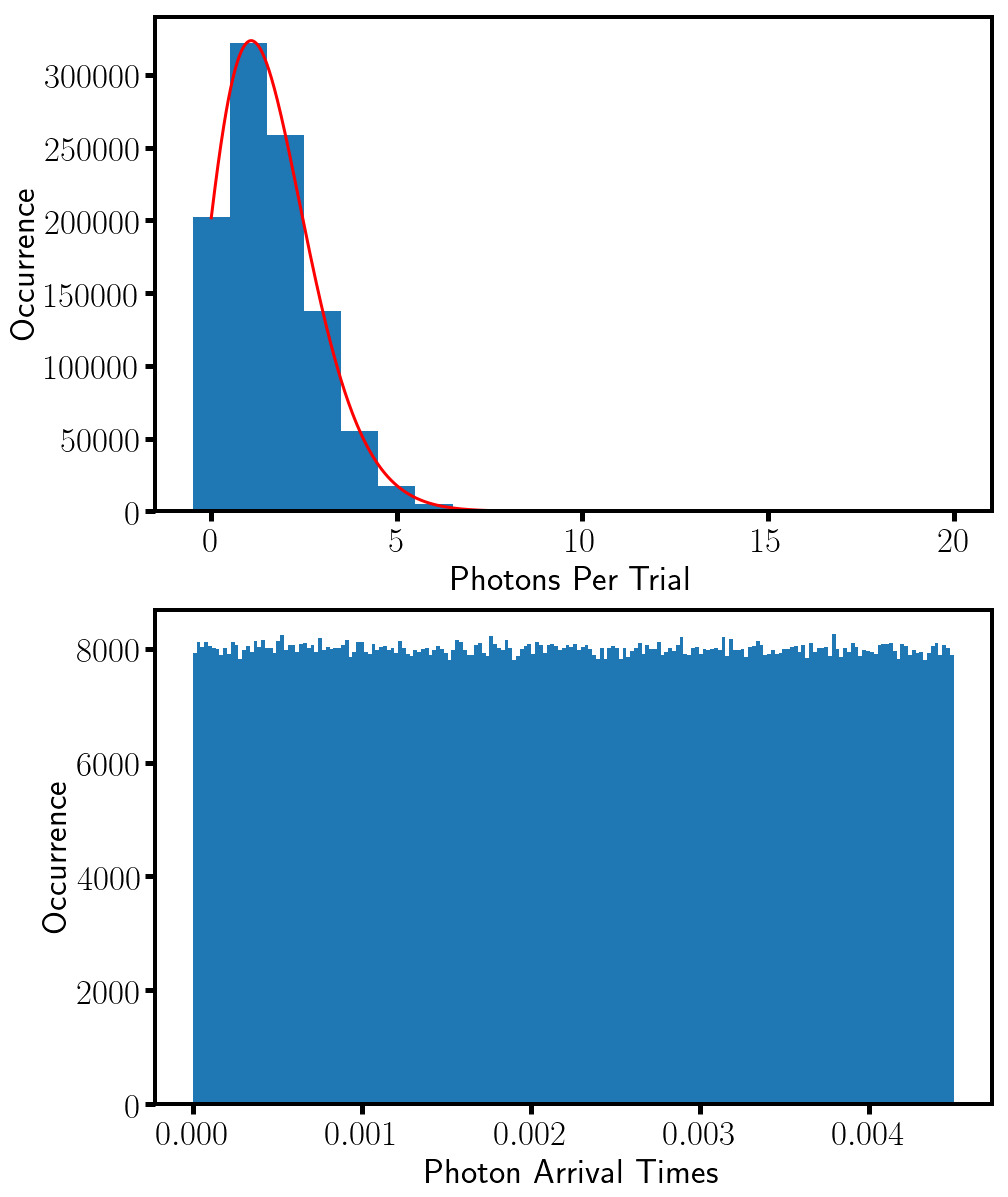

In [150]:
rcParams["figure.figsize"] = 15, 20
from scipy.optimize import curve_fit
from scipy.special import factorial

def poiss(x, mu):
        return (np.exp(-mu)*mu**x)/factorial(x)

    
    
# make a histogram of the total number of collected photons in each trial
# np.sum will give the total collected photons in each trial
total_dark_counts_by_trial_no_decay = np.sum(dark_state_trials_no_decay, axis = 1)
subplot(2,1,1)
dark_hist = hist(total_dark_counts_by_trial_no_decay.flatten(),bins = np.arange(0,np.amax(total_dark_counts_by_trial_no_decay)+1,1), align = 'left')

# grab x-y data for Lorentzian fit
x_dark = dark_hist[1][:-1]  
y_dark = dark_hist[0]/len(no_decay_events) # normalize for the fit

fit_dark_p, dark_err_p = curve_fit(poiss,x_dark, y_dark, p0 = [1.6])
print 'Dark Fit Poisson Mean: ', '{:.2f}'.format(fit_dark_p[0])
x_fit_dark = np.linspace(0,20,1000)
y_fit_dark = poiss(x_fit_dark, fit_dark_p[0])*len(no_decay_events)

plot(x_fit_dark,y_fit_dark,'r', linewidth = 3)
xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)

# plot photon arrival times
subplot(2,1,2)
all_tags = np.concatenate(dark_tags_by_trial_no_decay).ravel()
hist(all_tags, bins = 200)
xlabel(r'Photon Arrival Times', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)

show()

### Dark State With Decay

139


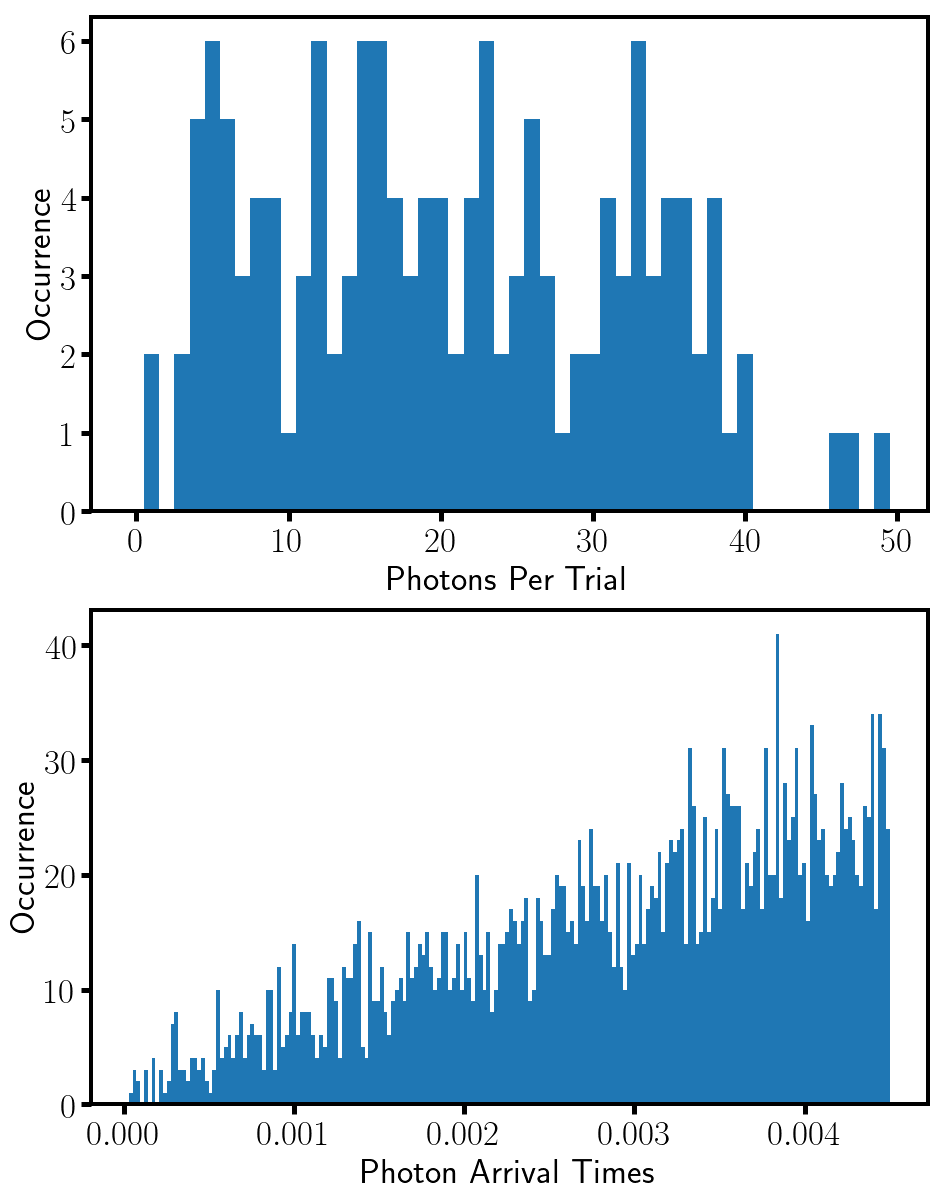

In [146]:
### Decay events    

# make a histogram of the total number of collected photons in each trial

# make list of total photons per trial
total_dark_counts_by_trial_decay = np.array([])
for i in range(len(dark_tags_by_trial_decay)):
    total_dark_counts_by_trial_decay = np.append(total_dark_counts_by_trial_decay, len(dark_tags_by_trial_decay[i]))

print len(dark_tags_by_trial_decay)
all_tags = np.concatenate(dark_tags_by_trial_decay).ravel()
subplot(2,1,1)
dark_hist = hist(total_dark_counts_by_trial_decay,bins = np.arange(0,np.amax(total_dark_counts_by_trial_decay)+1,1), align = 'left')


xlabel(r'Photons Per Trial', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)

# plot photon arrival times
subplot(2,1,2)
all_tags = np.concatenate(dark_tags_by_trial_decay).ravel()
hist(all_tags, bins = 200)
xlabel(r'Photon Arrival Times', fontsize = 35)
ylabel(r'Occurrence', fontsize = 35)
tick_params(labelsize = 35)
tick_params(width=5, length=10)


### Total Dark State

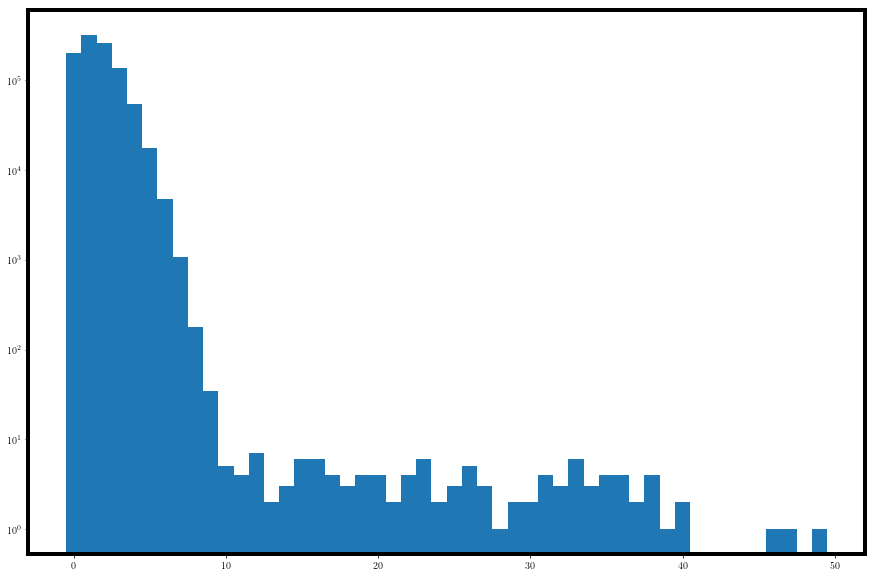

In [147]:
rcParams["figure.figsize"] = 15, 10
### Plot the total dark state on a log scale

total_dark = np.concatenate((total_dark_counts_by_trial_no_decay,total_dark_counts_by_trial_decay))

dark_hist = hist(total_dark,bins = np.arange(0,np.amax(total_dark)+1,1), align = 'left', log='True')